# Context for this coding & writing sample

I presented this notebook on Tuesday, April 29th to Fernando Perez's research group at UC-Berkely. I've modified it slightly to:

  1. Add context that I had previously noted verbally
  2. Reduce the computational complexity of the example so that it can run on a single binder instance
  3. Created a repository so that software dependencies can be built automatically, and the data is present.

This notebook can be run for free from any web browser be clicking the following binder link: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/espg/coding-sample/HEAD?urlpath=%2Fdoc%2Ftree%2FGaussianProcesses.ipynb)

# Gaussian Processes Prediction

Principle Component Analysis (PCA) and Empirical Orthogonal functions (EOF) are functionally the same numerical method, with EOFs being the preferred term in Atmospheric communities and PCA being the more general term used in broader statistical discussions. Similarly, Gaussian Processes is the general term used in physics and statistical learning for what the geosciences has traditionally termed 'kriging', and which some branches of math refer to as Wiener–Kolmogorov prediction.

Gaussian Processes (GP) are perhaps best thought of as a collection of enhancements to the traditional kriging system. They are functionally equivalent to kriging ([Williams (1998)]( https://doi.org/10.1007/978-94-011-5014-9_23)), and differ only in implantation details and slightly in philosophy; although the philosophical differences are in general extensions to ideas explicitly espoused by many kriging giants. **The GP philosophy treats interpolation as model selection from an infinite number of functions ([Rasmussen & Williams (2005)](https://doi.org/10.7551/mitpress/3206.001.0001))**. 

![gp.png](https://upload.wikimedia.org/wikipedia/commons/7/7f/Gaussian_Process_Regression.png)

This characterization certainly fits with [Matheron’s](https://doi.org/10.2307/1425829) discussion of random fields, and is a close match to [Journal’s](https://doi.org/10.1007/bf02067214) description of projection into various solution spaces. These functions are not required to be linear, as the figure below demonstrates: 

![animation.gif](https://upload.wikimedia.org/wikipedia/commons/d/da/Gaussianprocess.gif)

*As number of predictions 'P' grows to be large above, the mean of all 'P' approaches the best estimate, with the variance of predictions indicating confidence (std. dev. of predictions)*

**The primary object of interest in kriging is the variogram**, which is the main method by which practitioners fit a covariance function. **In contrast, the primary object of interest in GPs is the kernel, which is directly equivalent to covariances.** The kernel formulation has direct computational savings, enabling solving of high dimensional kernel functions in low dimensional space via the kernel trick (i.e., computing only the inner products) (@genton); the kernel formulation also admits easy translation to Fourier based methods when interpolating regular spaces ([Wilson & Adams (2013)](https://doi.org/10.48550/arXiv.1302.4245)). Kernel architecture is flexible, as valid kernels can be added or multiplied to form new synthesis kernels ([Cressie & Huang (1999)](https://doi.org/10.1080/01621459.1999.10473885 )). For instance, non-stationary kernels can be combined with stationary kernels and white noise kernels, such that large spatial trends, local correlation and structure, and intrinsic random noise and error can be modeled and specified as discrete submodules and functions-- [see here for a practical example using Mauna Loa data](https://towardsdatascience.com/gaussian-process-kernels-96bafb4dd63e/) in scikit-learn. Kernels can also be bounded for more efficient computation—for instance, circular and spherical kernels give rise to sparse gram matrices that can be reordered and solved by efficient sparse solvers; the Matérn kernel ([Matérn, 1960]( https://doi.org/10.1007/978-1-4615-7892-5)) can be modified to do the same. Separable non-stationary kernels can be written as a Kronecker tensor product (@genton), and solved in circulant matrixes by efficient Fourier methods ([Wilson & Nickisch (2015)](https://doi.org/10.48550/arXiv.1503.01057)).

Although Gaussian Processes is the more general statistical term for covariance methods of prediction, the practice and term of kriging predates Gaussian Processes. Thus, to explain the history and theory of Gaussian Processes, we'll start with kriging first.

## What is kriging (informally)?

Generally speaking, most people use kriging as an interpolator. Classic interpolators can be split into ‘*estimators*’ and ‘*predictors*’; this distinction (in line with [Cressie, 1990]( https://doi.org/10.1007/bf00889887)) mainly applies to highlight that ‘*estimators*’ provide an estimate of the surface, while ‘*predictors*’ assign a prediction that is accompanied by measures of confidence (probability, confidence interval).

![image.jpg](https://github.com/YuePanEdward/PPE_Kriging/blob/main/figures/result_dense_dataset.jpg?raw=true)

*Estimators including nearest neighbor, bilinear interpolation, and cubic spline (bottom), as compared with kriging predictions using three different kernels (top)*

Traditional ‘*estimators*’ are of the fairly boring type that most are fairly familiar with— canonical examples are bilinear interpolation, Inverse Distance Weighting (IDW), cubic convolution, etc. Other non-traditional examples of 'estimators' include things like nearest and natural neighbor interpolation, which are appropriate for specific domain cases when you want to preserve original data values. If your **goal** is **just** interpolation **and you have sufficient data**, using an estimator is perfectly fine-- and fast! However, if your data is **sparse**, kriging starts to become more appealing:


![image.jpg](https://github.com/YuePanEdward/PPE_Kriging/blob/main/figures/result_sparse_dataset.jpg?raw=true)

This sparse estimation capability is why kriging was originally developed. Kriging is named after Danie G. Krige, who's 1951 master's thesis developed and described what we call 'Ordinary Kriging'. Danie Krige was a prospector looking for gold in South Africa, an application that had sparse input measurements, and expensive sampling. Krige's method was coined 'kriging' by the early 1960's by French mathematician Georges Matheron, who formalized and expanded the method.

Of course, the other case where kriging is appealing is when you need to use the method as a *predictor*.

## Covariance, Gold, and the variogram model

![image.gif](https://vsp.pnnl.gov/help/image/Variogram.gif)

Traditional kriging defines a **model of covariance** by fitting a function to the empirical 'variogram', which plots the variance between observations as a function of distance between those observations. The variogram 'sill' refers to variance between uncorrelated samples, and the 'range' is the lag-distance at which this paired observation decorrelation occurs. The 'nugget' refers to the intrinsic variance (i.e., the observational uncertainty) at distance zero-- that is, the variance of a single point observation with itself. The term 'nugget' is literally referring to 'gold nugget' in the context of prospecting; i.e., finding a 'nugget' of gold which has been displaced from the source gold deposit... just because a 'nugget' is present at a location, does not guarantee that you are coincident with the deposit *that generated that observation*; however, the expectation is that the nugget is close!

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_noisy_targets_003.png)

Mathematically, specifying a 'nugget' value (or `alpha` in GP terminology) is effectively adding a constant to the diagonal of the covariance matrix such that each observation has some level of variance with itself. Doing this allows flexibility for the mean of the predictions to *not* intersect all of the observation points-- if covariance is set to zero along the diagonal, then any estimation will be a 'rubber sheeting' that ensures the output surface prediction passes through the original data points. Of course, we can also specify covariance *per observation* rather than as a constant along the diagonal, and selectively *down weight* low confidence observations.

## What I use Gaussian Processes for

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from osgeo import osr
import pyproj
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF

In [3]:
rng = np.random.default_rng() # new numpy sampling API

In [4]:
data = pd.HDFStore("./Z62SU06" + ".h5", 'r') # ICESat data
coordlist = data['coords'] # Needed for distance calculations / plotting
df_indices = data['indices'] # UUID to link to observations to slope retrievals
df_corr = data['corr'] # Filter and weight data

gslope = np.load('./General_slopes.npy') # Sub ICESat footprint slope retrievals
mean_slope = np.zeros(len(coordlist))
std_slope = np.zeros(len(coordlist))

# Merge and aggregate slope
for i in tqdm(range(len(coordlist))):
    sweights = np.array(df_corr.iloc[i].values)
    weightidx = np.isfinite(sweights)
    sweights = np.abs(sweights[weightidx])
    sidx = df_indices.iloc[i].values[weightidx]
    sidx = np.array(sidx, dtype=int)
    mean_slope[i] = np.average(gslope[sidx], weights=sweights)
    std_slope[i] = np.std(gslope[sidx])

  0%|          | 0/23359 [00:00<?, ?it/s]

This example is meant to be larger than a 'toy' dataset, but still small enough to interact with and demonstrate. Our input data consist of 23,359 observations (from the summer of 2006), which are within footprint slope retrievals from the first ICESat mission (which flew from 2003 to 2009, although laser power was strongest in the first three years).

Here's what the data looks like:

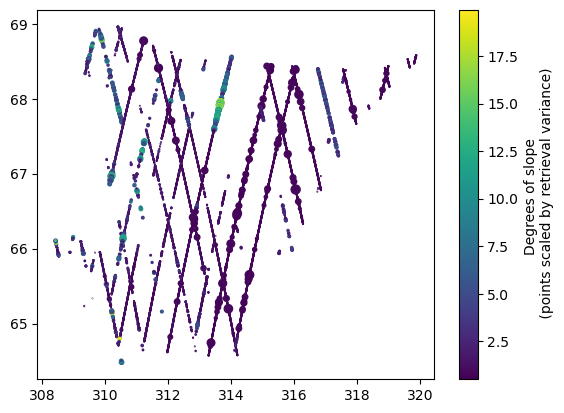

In [5]:
fig, ax = plt.subplots()
im = ax.scatter(coordlist.lon, coordlist.lat, c=mean_slope, s=std_slope**2)
im.set_clim(min(mean_slope), max(mean_slope))
fig.colorbar(im, ax=ax, label="Degrees of slope \n (points scaled by retrieval variance)")
plt.show()

This is an interesting case of geostatistics because the sampling is quite odd-- the along track resolution is dense, but the across track resolution is sparse. Most of the code is actually setting up the **source** and **target** coordinate systems for the model. The input observational data is irregularly spaced and in lat/lon coordinates, but we want our distance measurements to be in euclidean space and output to a grid.

We also want to 'clip' the results to a drainage basin. This is for two reasons-- first, the drainage basin boundries are of zero surface slope and provide a physically meaningful way to bound, divide, and tile the analysis. And second, covariance functions are expensive, so clipping and masking the edges of our area of interest helps things run faster... it also makes the output look good!

In [6]:
# Projection object
ds = osr.SpatialReference()
ds.ImportFromEPSG(3411) # polar projection
ds.ExportToProj4()
p2 = pyproj.Proj(ds.ExportToProj4())

# Observations to meters from lat / lon
X, Y = p2(np.array(coordlist.lon),
          np.array(coordlist.lat))
# To vector form sklearn
coords_m = np.ones((len(coordlist),2))
coords_m[:,0] = X
coords_m[:,1] = Y

# Drainage basin boundries
zwally = pd.read_csv('./GrnDrainageSystems_Ekholm.txt',
                     sep=r"\s+", names=['basin', 'lat','long'])
basin = '6.2'
LL = zip(zwally[zwally.basin == float(basin)].long,
         zwally[zwally.basin == float(basin)].lat)
LL = list(LL)
# Convert basin boundries to meters from lat / lon
pX, pY = p2(np.array(LL)[:,0],
            np.array(LL)[:,1])
# Polygon object for masking
Z = mpl.path.Path(list(zip(pX, pY)))

# Setting up kriging grid
x1, y1 = np.meshgrid(np.r_[round(min(pX), -2) - 2500:round(max(pX), -2) + 2500:5000],
                     np.r_[round(min(pY), -2) - 2500:round(max(pY), -2) + 2500:5000])
kcoords = np.vstack([x1.ravel(),y1.ravel()]).T

# Masking kriging grid
Zidx = Z.contains_points(kcoords[:])
target_c = kcoords[Zidx] # Target coordinates
x1.shape, len(target_c)

((108, 110), 5600)

At this point, we've setup a 2-km grid to predict on that's 267 by 273 (a little over 500km per side), which after masking has 34,984 target coordinate locations to predict at. The actual Gaussian Process model specification is fairly short:

In [7]:
ind = np.array(range(0,len(coordlist)), dtype=int)
idxs = np.random.choice(ind, size=4000)

In [34]:
%%time
noise = WhiteKernel(noise_level=.5)
rbf = 3 * RBF(length_scale=[80000,80000])
kern = 2.0 * Matern(length_scale=[80000,80000], length_scale_bounds=(1e3, 1e6),
                        nu=0.5)
gp1 = GaussianProcessRegressor(kernel=rbf+kern+noise, alpha=std_slope[idxs]**2, optimizer=None).fit(coords_m[idxs], mean_slope[idxs])

CPU times: user 5.04 s, sys: 2.32 s, total: 7.36 s
Wall time: 1.16 s


We are specifying a `Matern` kernel to calculate and estimate our covarience, which is defined by the single parameter `nu`; this parameter controls how smooth the fuctions are within our prior distribution of possible surface functions. It is set at 0.5 (i.e., '1 / 2', equivelent the absolute exponential kernel) to allow rough, non-differentiable candidate functions; a `nu=1.5` (3 / 2) will select from functions that are once differentiable, `nu=2.5` (5 / 2) will select from functions that are twice differentiable, and `nu=inf` will converge to the infinately differentiable RBF kernel.

The `length_scale` parameter would typically be optimized during model fit based on the spatial structure of the data... however, because our input data is heavily unbalanced (i.e., dense in the along track direction, sparse in the across track), hyper-parameter optimization sets a length scale that is too short, so it is fixed at 80km, with similar settings applied for the `length_scale_bounds`.

After model specification, at `fit` time we provide the coordinates, and slope values, along with an `alpha` that is set to varience of slope retrieval (i.e., estimates of varience per observation).

Doubling the number of observations (by adding a second summer of orbits) pushes the model fit time from under two minutes to about a half hour (although some of this is due to the higher memory footprint and pressure causing the OS to begin swapping to disk).

We can get the mean surface estimate and target-to-target covariances with the following:

In [35]:
%%time
y_mean, y_cov = gp1.predict(target_c, return_cov=True)

CPU times: user 10.9 s, sys: 896 ms, total: 11.8 s
Wall time: 1.82 s


The mean predictions need to be reshaped before plotting:

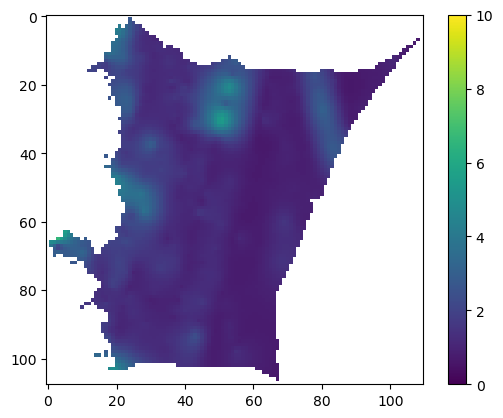

In [36]:
# slope
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  y_mean
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1), vmin=0, vmax=10)
plt.colorbar()
plt.show()

## What is kriging (formally)?

Mathematically, kriging is the Best Unbiased Linear **Predictor** (@10.1007/bf02067214 ; @10.1007/bf00889887 ; @10.1080/00401706.1993.10485354), and provides the Best Linear Unbiased Prediction, or BLUP; this means that kriging prediction is a linear combination of weighted observations at point p that minimizes prediction variance. Note that this is different (but related) to the Best Linear Unbiased **Estimation**, or BLUE... although when using kriging to *estimate* a quantity, the results will be equivilent to the BLUE, which is why kriging is often conceptually understood as equivalent to spatially weighted generalized least squares regression. There are of course various flavors of kriging (simple, ordinary, universal, etc.) (see [Journel](10.1007/bf02067214)), but below is mathematical formulation for simple kriging (other flavors are similar):

Given N observations (s1…sn), and CovF(distance) covariance function, calculate D distances of N observations; note the convention of using $t$ for *target* and $s$ for *source*:

$$D(s_1 ... s_n, s_1 ... s_n) = D_{obs}$$
$$C_{obs} = f_{cov}(D_{obs}) \quad \textrm{or} \quad C(\mathbf{x}_n, \mathbf{x}_m) = k(\mathbf{x}_n, \mathbf{x}_m)$$

    Dist(s1…sn, s1…sn) = Dobs  		# square distance matrix
    Cobs = CovF(Dobs)                       # observation covarience, i.e., source-to-source cov

**This is what is happening here:**

```python
kern = 1.0 * Matern(length_scale=[80000,80000], length_scale_bounds=(1e3, 1e6),
                        nu=0.5)
gp1 = GaussianProcessRegressor(kernel=kern, alpha=std_slope**2, optimizer=None).fit(coords_m, mean_slope)
```

**We are selecting a covariance function (the Matern kernel), and then fitting that fuction to our observations on the basis of distance in order to estimate source-to-source cov**

Define p1…pn prediction nodes; calculate distances and Cpred (covariance of predictions):

$$D(t_1 ... t_n, t_1 ... t_n) = D_{pred}$$
$$C_{pred} = f_{cov}(D_{pred})$$

    Dist(t1…tn, t1…tn) = Dpred  		# square distance matrix
    Cpred = CovF(Dpred)                     # target covarience, i.e., target-to-target cov

Note that for above, we don’t actually know p1…pn *but we do know the locations* of p1…pn, and hence we can calculate their distances, and given that our covariance function is a function of distances, we can **model** the covariance of the predictions p1…pn as a function of distance.

As mentioned above, kriging is equivalent to spatial least squares regression. Hence, we can retrieve our best estimate at locations p1…pn though least square regression—see below for useful equivalencies:

    Lstsq( s1…sn, t1…tn) == Lstsq( Cobs, Cobs_pred) == kriging_wieghts

…where `Cobs_pred` is the covariance between our observations and predictions, i.e., our target-to-source `cov`. Of course, we don’t know our predictions yet; all we have are our observations, and our observation covariances. However, we have defined a covariance function, ***based*** on our observation covariances, that provides covariance as a function of distance; hence above we defined our prediction to prediction covariance. 

**The kriging weights are used to weight a combination of our observations at each prediction location-- with the weights being determined by distance and the covariance structure. Our 'mean' prediction and target-to-target cov (and the steps above and below to retrieve them), happen at this call:**

```python
y_mean, y_cov = gp1.predict(target_c, return_cov=True)
```

**(Note, this call is also implicitly calculating the source to target covariance!)**

Using the same assumption that covariance can be specified as a function of distance, we can get an estimate of covariance between our observations and prediction locations:

    Cobs_pred = CovF(Dist(s1…sn, t1…tn)

…now we obtain the kriging weights by:

    kriging_wieghts = dot(inv(Cobs), Cobs_pred)

Above we see the key computational constraint for kriging; we need to be able to invert an N by N observation covariance matrix.

Given that the regression/kriging weights are identical for both the observations and their covariances, we now have enough information to make a kriging/Lstsq’s prediction of t1…tn:

    t1…tn =  dot(kriging_wieghts.T, s1…sn)

We can calculate partial correlation/covariance, which is equivalent to the covariance of the residual error from kriging/regression. We get conditional covariance with:

    Cpred – dot(dot(Cobs_pred.T, inv(Cobs)), Cobs_pred)

The above gives the estimation error covariance, and allows for simulation, i.e., *prediction*. Specifically, we can preform simulation via Cholesky decomposition\* using the derived mean target predictions, and the target-to-target covariance:

(from [sklearn gaussian process module](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/gaussian_process/_gpr.py)):
```python
    def sample_y(self, X, n_samples=1, random_state=0):
        """Draw samples from Gaussian process and evaluate at X.

        Parameters
        ----------
        X : array-like of shape (n_samples_X, n_features) or list of object
            Query points where the GP is evaluated.

        n_samples : int, default=1
            Number of samples drawn from the Gaussian process per query point.

        random_state : int, RandomState instance or None, default=0
            Determines random number generation to randomly draw samples.
            Pass an int for reproducible results across multiple function
            calls.
            See :term:`Glossary <random_state>`.

        Returns
        -------
        y_samples : ndarray of shape (n_samples_X, n_samples), or \
            (n_samples_X, n_targets, n_samples)
            Values of n_samples samples drawn from Gaussian process and
            evaluated at query points.
        """
        rng = check_random_state(random_state)

        y_mean, y_cov = self.predict(X, return_cov=True)
        if y_mean.ndim == 1:
            y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
        else:
            y_samples = [
                rng.multivariate_normal(
                    y_mean[:, target], y_cov[..., target], n_samples
                ).T[:, np.newaxis]
                for target in range(y_mean.shape[1])
            ]
            y_samples = np.hstack(y_samples)
        return y_samples
```

Several things are apparent for the kriging description above, that highlight both the strengths and weakness of the approach. First and foremost, *the approach is completely dependent on specification of a proper covariance function*. **The covariance function must be invertible; that is it must be positive definite (Genton, 2002)**, and the machine that runs the computation must be capable of inverting a N by N matrix. In practice, the N by N inversion can be relaxed if only the ‘best’ prediction is desired (since it can be derived via lstsq calculation); *however, simulation and error estimation requires inversion of an N by N matrix.* **In practice, empirical covariance almost always provides a non-invertible (not positive definite) gram matrix (@10.1080/00401706.1993.10485354); further, a model of covariance is needed to estimate source to target and target to target covariance—so estimation of a covariance function, either via a variogram or by other methods, is always required for geostatistical interpolation and simulation.** The error estimation that kriging gives per prediction is error estimation on the assumption that modeled covariance structure is true! Kriging has been characterized as the Best Unbiased Linear Predictor (BULP)… which it is, for a given covariance function. Swapping covariance functions gives different and competing BLUPs, which then need to be evaluated via inter-model comparison ([]( https://doi.org/10.1162/neco.1992.4.3.415)). In short, the kriging error and uncertainty estimation is not the absolute error estimate for the surface, and probability estimation of a prediction must be obtained with other models to give realistic confidence bounds.

\*Traditional kriging involves estimation of a variogram, however, the variogram is simply a way of producing a covariance function that produces a positive definite gram matrix of covariances (Genton, 2002). Since we know that our covariance function produces a positive definite gram matrix of covariances, we use cholesky because [it is faster than SVD or eigen decomposition](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.Generator.multivariate_normal.html#numpy.random.Generator.multivariate_normal).


## Why Prediction?

Slope is an important variable for glaciologists, but it also doesn't vary much on the icesheet-- it goes from about 2 degrees at the edge where it's 'steep', before gradually dropping down to 1 in the interior and eventually 0 at the drainage boundary. However, things change when the surface is crevassed; cracks present a range of surface heights and angles, and generally those retrievals are **not** flat.

So if we are looking for crevasses, and we know that the 'background' slope of the ice sheet is 2 degrees of slope or lower, it would be nice to know when that slope is exceeded. Unfortunately, our mean prediction of surface slope is smoothing the variation in slope retrievals-- if we have a distribution of slope values, the best prediction will trend towards the mean, resulting in surface that suppresses variation we know is present.

What we can do though, is simulate possible surfaces, and count how often we exceed 2 degrees of slope for a given location:

In [40]:
%%time
realizations = rng.multivariate_normal(y_mean, y_cov, size=100, method='cholesky')

CPU times: user 6.4 s, sys: 666 ms, total: 7.06 s
Wall time: 779 ms


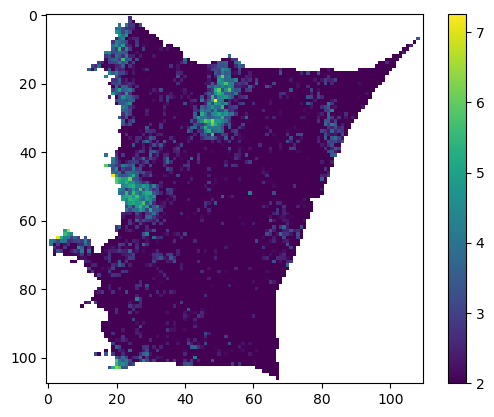

In [41]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  realizations[5]
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1), vmin=2)
plt.colorbar()
plt.show()

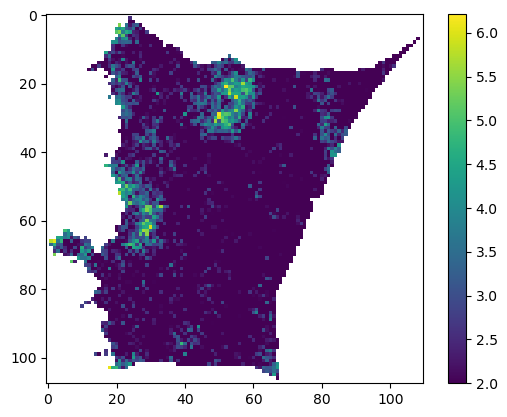

In [42]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  realizations[2]
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1), vmin=2)
plt.colorbar()
plt.show()

In [43]:
occurance = np.zeros(5600, dtype=np.int64)
for i in realizations:
    occurance += i > 3

In [71]:
np.shape(show_res1[:,0:500])

(108, 110)

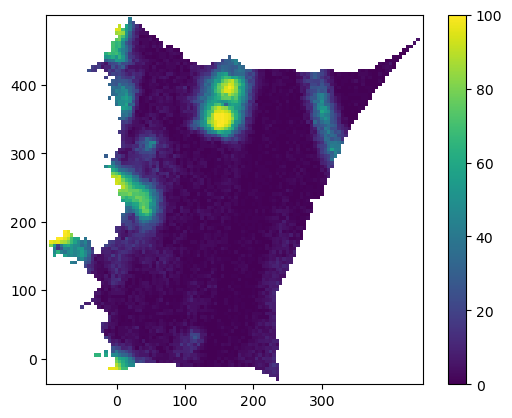

In [73]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  occurance
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1)) #, norm=mpl.colors.LogNorm())
ticks = np.array([0,20,40,60,80])
yticks = np.array([100,80,60,40,20])
plt.xticks(ticks[1:],(ticks[0:-1]*5))
plt.yticks(yticks,(ticks*5))
plt.colorbar()
plt.show()

## Covarience Kernels

Observe the following GP kernels (i.e., covarience models), fitted to the same data; note that every model consistently *predicts* an additional drop *beyond the observations* between x=4 and x=5; interpolation using most estimators cannot exceed the min/max of the observation space! 

![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_001.png)
![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_002.png)

*Note that the next kernel is modeling period functions (applicable to basin and range features)*

![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_003.png)
![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_005.png)

Note that one major benefit to the GP kernel formulation is that [kernels can be *combined*](https://towardsdatascience.com/gaussian-process-kernels-96bafb4dd63e/). This approach models kernels to account for the non-stationarity of the processes within the kernel formulation, rather than seperating out a

## References
1.	Cressie, Noel. "The origins of kriging." Mathematical geology 22.3 (1990): 239-252. 
2.	Cressie, Noel, and Hsin-Cheng Huang. "Classes of nonseparable, spatio-temporal stationary covariance functions." Journal of the American Statistical Association 94.448 (1999): 1330-1339.
3.	Genton, Marc G. "Classes of kernels for machine learning: a statistics perspective." The Journal of Machine Learning Research 2 (2002): 299-312. 
4.	Handcock, Mark S., and Michael L. Stein. "A Bayesian analysis of kriging." Technometrics 35.4 (1993): 403-410.
5.	Journel, Andre G. "Kriging in terms of projections." Journal of the International Association for Mathematical Geology 9.6 (1977): 563-586. 
6.	MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.
7.	MacKay, David JC. "A practical Bayesian framework for backpropagation networks." Neural computation 4.3 (1992b): 448-472.
8.	Matérn, Bertil. "Spatial variation." (1960). 
9.	Matheron, Georges. "The intrinsic random functions and their applications." Advances in applied probability (1973): 439-468.
10.	Rasmussen, Carl Edward. "Gaussian processes for machine learning." (2006). 
11.	Simpson, Daniel, Finn Lindgren, and Håvard Rue. "In order to make spatial statistics computationally feasible, we need to forget about the covariance function." Environmetrics 23.1 (2012): 65-74.
12.	Williams, Christopher KI. "Prediction with Gaussian processes: From linear regression to linear prediction and beyond." Learning in graphical models. Springer Netherlands, 1998. 599-621.
13.	Wilson, Andrew Gordon. Covariance kernels for fast automatic pattern discovery and extrapolation with Gaussian processes. Diss. PhD thesis, University of Cambridge, 2014.
14.	Wilson, Andrew Gordon, and Hannes Nickisch. "Kernel interpolation for scalable structured Gaussian processes (KISS-GP)." arXiv preprint arXiv:1503.01057 (2015).